In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [202]:
data = pd.read_csv('data.csv')
data = data.drop('country', axis=1)

display(data.head())

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [204]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]

X = (data - data.min()) / (data.max() - data.min())
display(X.head())

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.650224,0.113963,0.570702,0.484514,0.022348,0.434279,0.140468,0.862782,0.010534
1,0.100149,0.321358,0.465921,0.524500,0.208100,0.236516,0.812709,0.078947,0.126239
2,0.180120,0.441186,0.223805,0.338622,0.274408,0.700360,0.819398,0.312030,0.138343
3,0.865471,0.716560,0.089522,0.462901,0.118126,0.952058,0.270903,0.926692,0.107920
4,0.053064,0.522992,0.413021,0.635810,0.412828,0.114662,0.829431,0.169173,0.391540


In [206]:
def pca(X, n_components=2):
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # Compute covariance matrix
    cov_matrix = np.cov(X_centered.T)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    # Select top n_components
    selected_eigenvectors = sorted_eigenvectors[:, :n_components]
    
    # Project data onto new feature space
    X_pca = X_centered @ selected_eigenvectors
    
    # Calculate explained variance ratio
    total_variance = np.sum(sorted_eigenvalues)
    explained_variance_ratio = sorted_eigenvalues[:n_components] / total_variance
    print(explained_variance_ratio)
    return X_pca, explained_variance_ratio

# Apply PCA
X_pca, explained_variance = pca(X)


[0.51127001 0.14395056]


In [208]:
class KMeans:
    def __init__(self, n_clusters=3, max_iters=300, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        np.random.seed(random_state)
    
    def fit(self, X):
        # Ensure X is a NumPy array
        X = np.array(X)
        
        # Random initialization of centroids
        centroid_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[centroid_indices, :]  # NumPy slicing
        
        for _ in range(self.max_iters):
            # Assign clusters
            distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :])**2).sum(axis=2))
            prev_labels = getattr(self, 'labels', None)
            self.labels = np.argmin(distances, axis=1)
            
            # Update centroids
            new_centroids = np.array([X[self.labels == k].mean(axis=0) for k in range(self.n_clusters)])
            
            # Check for convergence
            if prev_labels is not None and np.array_equal(prev_labels, self.labels):
                break
            
            self.centroids = new_centroids
        
        return self


In [210]:
# Perform K-means Clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_pca)

# Ensure X_pca is a NumPy array for compatibility
X_pca_np = X_pca if isinstance(X_pca, np.ndarray) else X_pca.to_numpy()

In [212]:
def silhouette_score(X, labels):
    n_samples = X.shape[0]
    unique_labels = np.unique(labels)
    
    silhouette_values = []
    
    for i in range(n_samples):
        # Compute a(i) - average distance to points in the same cluster
        same_cluster_mask = labels == labels[i]
        if np.sum(same_cluster_mask) > 1:
            a_i = np.mean(cdist([X[i]], X[same_cluster_mask])[0])
        else:
            a_i = 0
        
        # Compute b(i) - minimum average distance to points in other clusters
        b_i_values = []
        for cluster in unique_labels:
            if cluster != labels[i]:
                other_cluster_mask = labels == cluster
                if np.sum(other_cluster_mask) > 0:
                    b_i = np.mean(cdist([X[i]], X[other_cluster_mask])[0])
                    b_i_values.append(b_i)
        
        # Minimum distance to other clusters
        b_i = min(b_i_values) if b_i_values else 0
        
        # Silhouette value for this point
        silhouette_values.append((b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0)
    
    return np.mean(silhouette_values)


In [214]:
def calculate_inertia(X, labels, centroids):
    inertia = 0.0
    for i, point in enumerate(X):
        # Distance between point and its cluster's centroid
        centroid = centroids[labels[i]]
        inertia += np.sum((point - centroid) ** 2)
    return inertia
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)

In [216]:
def calculate_dunn_index(X, labels, centroids):
    # Inter-cluster distance (minimum distance between centroids of different clusters)
    inter_cluster_distances = cdist(centroids, centroids, metric='euclidean')
    np.fill_diagonal(inter_cluster_distances, np.inf)  # Ignore self-distances
    min_inter_cluster_distance = np.min(inter_cluster_distances)
    
    # Intra-cluster distance (maximum distance within a single cluster)
    max_intra_cluster_distance = 0
    for k in np.unique(labels):
        cluster_points = X[labels == k]
        if len(cluster_points) > 1:
            intra_distances = cdist(cluster_points, cluster_points, metric='euclidean')
            max_intra_cluster_distance = max(max_intra_cluster_distance, np.max(intra_distances))
    
    # Calculate Dunn Index
    dunn_index = min_inter_cluster_distance / max_intra_cluster_distance if max_intra_cluster_distance != 0 else np.inf
    return dunn_index
dunn_index = calculate_dunn_index(X_pca, kmeans.labels, kmeans.centroids)

In [218]:
print("Clustering Evaluation:")
print(f"Silhouette Score: {silhouette_score(X_pca_np, kmeans.labels)}")
print(f"Dunn Index: {dunn_index}")
print(f"Inertia (Within-Cluster Sum of Squares): {inertia}")

Clustering Evaluation:
Silhouette Score: 0.40066608255092556
Dunn Index: 0.4302191663769939
Inertia (Within-Cluster Sum of Squares): 1.5775183278795455


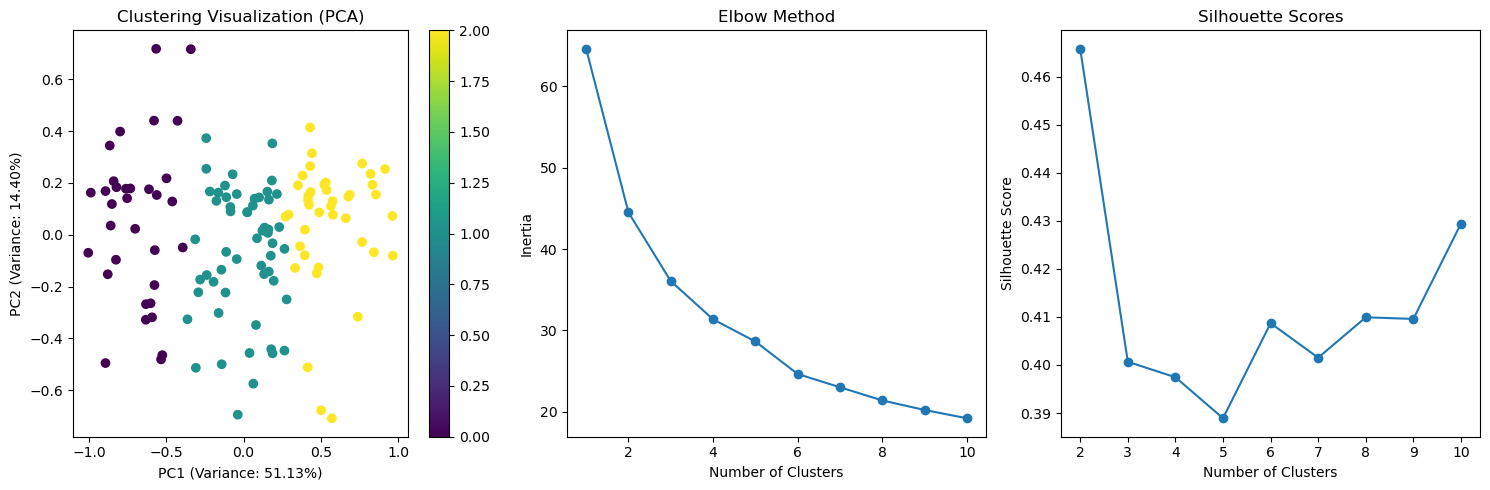

In [220]:
# Visualizations
plt.figure(figsize=(15, 5))

# Scatter plot of PCA components
plt.subplot(131)
scatter = plt.scatter(X_pca_np[:, 0], X_pca_np[:, 1], c=kmeans.labels, cmap='viridis')
plt.title('Clustering Visualization (PCA)')
plt.xlabel(f'PC1 (Variance: {explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 (Variance: {explained_variance[1]*100:.2f}%)')
plt.colorbar(scatter)

# Elbow Method
plt.subplot(132)
inertias = []
for k in range(1, 11):
    kmeans_temp = KMeans(n_clusters=k)
    kmeans_temp.fit(X_pca_np)
    inertias.append(sum(np.min(cdist(X_pca_np, kmeans_temp.centroids, 'euclidean'), axis=1)))

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Silhouette Scores
plt.subplot(133)
silhouette_scores = []
for k in range(2, 11):
    kmeans_temp = KMeans(n_clusters=k)
    kmeans_temp.fit(X_pca_np)
    silhouette_scores.append(silhouette_score(X_pca_np, kmeans_temp.labels))

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()